# MOVIE STUDIO ANALYSIS

<img src="./moviedog.jpg" style="width:100%; height:auto;">

## Business Understanding

Our company have decided to create a new movie studio, but they don’t know anything about creating movies. We have been charged with exploring what types of films are currently doing the best at the box office. We must then translate the findings into actionable insights that the head of the company's new movie studio can use to help decide what type of films to create.

* Our focus will be to make suggestions for the type of movies that will be the most profitable for our new movie division.

## Data Understanding

We will be using the following datasets:

1. `rt.reviews.tsv` [from rotten tomatoes](https://www.rottentomatoes.com/)
2. `im.db` from [IMDB](https://www.imdb.com/)
3. `rt.movie_info.tsv`[from rotten tomatoes](https://www.rottentomatoes.com/)
4. `tn.movie_budgets.csv` from [NUMBERS](https://www.the-numbers.com/)

## Importing Libraries

In [9]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

#### Loading Datasets

In [10]:
# reviews dataset
review_df = pd.read_csv('rt.reviews.tsv', sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')
#review_df.head()

# bom.movie_gross.csv
movie_gross_df = pd.read_csv('bom.movie_gross.csv')
#movie_gross_df

# im.dbsqlite, we load only the 2 tables that are needed for the analysis. 
conn = sqlite3.connect('im.db')
q = '''
    SELECT *
    FROM movie_basics
    JOIN movie_ratings
    ON movie_basics.movie_ID = movie_ratings.movie_id
'''
imdb_df = pd.read_sql(q, conn)
imdb_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119
...,...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,tt9913084,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",tt9914286,8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5


In [11]:
# Loading 'The Numbers' Dataset
path = 'tn.movie_budgets.csv'
movie_budgets_df = pd.read_csv(path)
movie_budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [12]:

movie_info_df = pd.read_csv('rt.movie_info.tsv',sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')

## Data Cleaning

#### 1.1 Merge review_df and Movie_df and clean the data

In [13]:
merged_df = pd.merge(review_df, movie_info_df, on='id', how='inner')


#### 1.2 Dropping columns from merged_df

In [14]:
# columns to drop
columns_to_drop =['review', 'critic', 'top_critic', 'publisher', 'synopsis', 'writer', 'studio']

merged_df = merged_df.drop(columns_to_drop, axis=1)


#### 1.3 Changing column names

In [15]:
merged_df = merged_df.rename(columns={'rating_x': 'star_rating', 'rating_y': 'MPAA_rating'})
# # 2. Drop rows with missing values in specific columns
# merge_df.dropna(subset=['theater_date', 'dvd_date'], inplace=True)

# # 3. Impute missing values
# merge_df['runtime'].fillna(merge_df['runtime'].mean(), inplace=True)

# # 4. Fill with specific values
# merge_df['director'].fillna('Unknown', inplace=True)

In [16]:
# Function to convert star ratings to a 0-10 scale
def convert_rating(rating):
    if pd.isna(rating):
        return np.nan
    
    # Handle mixed fractions (e.g., '3 1/2')
    if ' ' in rating and '/' in rating:
        whole, frac = rating.split(' ')
        num, denom = frac.split('/')
        return (float(whole) + float(num) / float(denom)) * 10 / (10 / float(denom))
    
    # Convert fraction ratings (e.g., '3/5')
    if '/' in rating:
        num, denom = rating.split('/')
        num = float(num)
        denom = float(denom)
        return (num / denom) * 10
    
    # Convert letter grades
    letter_grades = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 2.5, 'F+': 2, 'F-': 1.5
    }
    if rating in letter_grades:
        return letter_grades[rating]
    
    # Handle unconventional ratings ('N', 'R', etc.)
    unconventional_ratings = {
        'N': np.nan, 'R': np.nan  # Treat as missing values or set specific values
    }
    if rating in unconventional_ratings:
        return unconventional_ratings[rating]
    
    # Convert direct numeric ratings if within the range
    try:
        value = float(rating)
        if 0 <= value <= 10:
            return value
    except ValueError:
        pass
    
    return np.nan

# Apply conversion function to the star_rating column
merged_df['standardized_rating'] = merged_df['star_rating'].apply(convert_rating)

# Display the DataFrame with standardized ratings
merged_df

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,currency,box_office,runtime,standardized_rating
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,6.0
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54427,2000,NaN,fresh,"September 24, 2002",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,NaN
54428,2000,1/5,rotten,"September 21, 2005",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,2.0
54429,2000,2/5,rotten,"July 17, 2005",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,4.0
54430,2000,2.5/5,rotten,"September 7, 2003",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,5.0


#### 1.3 Checking and Dealing with Missing Values

In [17]:
merged_df.isna().sum()


id                         0
star_rating            13517
fresh                      0
date                       0
MPAA_rating               86
genre                     87
director                5440
theater_date            1226
dvd_date                1226
currency               21122
box_office             21122
runtime                  838
standardized_rating    13526
dtype: int64

In [19]:
merged_df['standardized_rating'].fillna(merged_df['standardized_rating'].mean())
merged_df = merged_df.dropna(subset=['MPAA_rating', 'genre'])

In [22]:
# # cleaning currency strings
# def clean_currency(x):
#     if isinstance(x, str):
#         return float(x.replace('$', '').replace(',', ''))
#     return x

# # Clean and convert monetary columns to numeric
# columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
# for col in columns_to_clean:
#     movie_budgets_df[col] = movie_budgets_df[col].apply(clean_currency).astype(float)

In [23]:
# drop 'star_rating' column
merged_df.drop('star_rating', axis=1, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_12412\2815547901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop('star_rating', axis=1, inplace=True)


#### Checking and Dropping any Duplicates

In [25]:
duplicates = merged_df.duplicated().sum()
merged_df= merged_df.drop_duplicates()


In [26]:
# 1. Drop rows with missing values in specific columns
merged_df.dropna(subset=['theater_date', 'dvd_date'])

# 2. Fill with specific values
merged_df['director'].fillna('Unknown')

0        David Cronenberg
1        David Cronenberg
2        David Cronenberg
3        David Cronenberg
4        David Cronenberg
               ...       
54427             Unknown
54428             Unknown
54429             Unknown
54430             Unknown
54431             Unknown
Name: director, Length: 40407, dtype: object

In [27]:
# extract minutes in the runtime dataset
merged_df['runtime'] = merged_df['runtime'].str.extract('(\d+)').astype(float)

# fill the missing runtime values with the mean
merged_df['runtime'].fillna(merged_df['runtime'].mean(), inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_12412\3809561258.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['runtime'].fillna(merged_df['runtime'].mean(), inplace=True)


### 2 Movie_budget_df

In [28]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


#### Check for Null Values

In [29]:
movie_budgets_df.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

#### Check for Duplicates

In [ ]:
movie_budgets_df

In [30]:
duplicated_rows = movie_budgets_df[movie_budgets_df.duplicated()]


### Imdb Dataset

In [32]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   movie_id         73856 non-null  object 
 7   averagerating    73856 non-null  float64
 8   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


#### Checking for Duplicates

In [34]:
dup_rows = imdb_df[imdb_df.duplicated]

#### Checking and Dropping Nulls

In [36]:
imdb_df = imdb_df.dropna(subset = ['runtime_minutes', 'genres'])
imdb_df.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
movie_id           0
averagerating      0
numvotes           0
dtype: int64

## Univariate Analysis

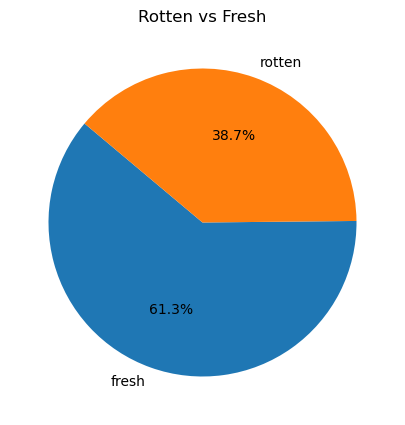

In [37]:
frequencies = merged_df['fresh'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 5))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=140)
plt.title('Rotten vs Fresh')
plt.show()

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


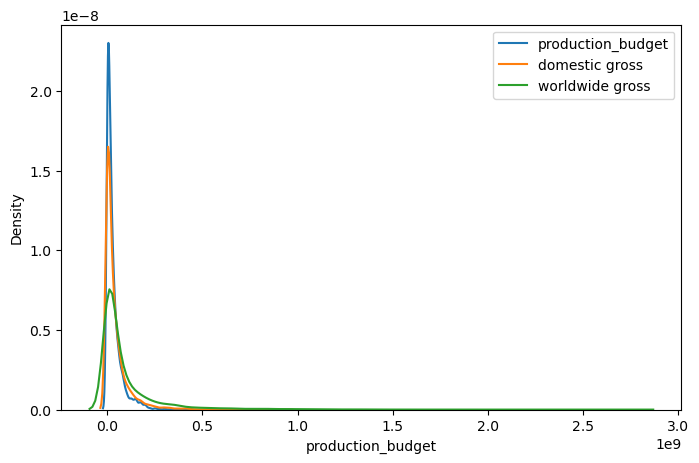

In [38]:
plt.figure(figsize=(8, 5))
sns.kdeplot(movie_budgets_df['production_budget'], label='production_budget')
sns.kdeplot(movie_budgets_df['domestic_gross'], label='domestic gross')
sns.kdeplot(movie_budgets_df['worldwide_gross'], label='worldwide gross')
plt.legend()
plt.show()

#### Converting Data Types

In [31]:
movie_budgets_df['release_date'] = pd.to_datetime(movie_budgets_df['release_date'])

# Function to remove dollar signs and commas and convert to numeric
def clean_currency(column):
    return column.replace('[\$,]', '', regex=True).astype(float)

# Apply the function to the budget and gross columns
movie_budgets_df['production_budget'] = clean_currency(movie_budgets_df['production_budget'])
movie_budgets_df['domestic_gross'] = clean_currency(movie_budgets_df['domestic_gross'])
movie_budgets_df['worldwide_gross'] = clean_currency(movie_budgets_df['worldwide_gross'])

movie_budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00


In [12]:
# Summary statistics
print(movie_budgets_df.describe())

# Correlation between budget and gross earnings
print(movie_budgets_df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr())


                id  production_budget  domestic_gross  worldwide_gross
count  5782.000000       5.782000e+03    5.782000e+03     5.782000e+03
mean     50.372363       3.158776e+07    4.187333e+07     9.148746e+07
std      28.821076       4.181208e+07    6.824060e+07     1.747200e+08
min       1.000000       1.100000e+03    0.000000e+00     0.000000e+00
25%      25.000000       5.000000e+06    1.429534e+06     4.125415e+06
50%      50.000000       1.700000e+07    1.722594e+07     2.798445e+07
75%      75.000000       4.000000e+07    5.234866e+07     9.764584e+07
max     100.000000       4.250000e+08    9.366622e+08     2.776345e+09
                   production_budget  domestic_gross  worldwide_gross
production_budget           1.000000        0.685682         0.748306
domestic_gross              0.685682        1.000000         0.938853
worldwide_gross             0.748306        0.938853         1.000000


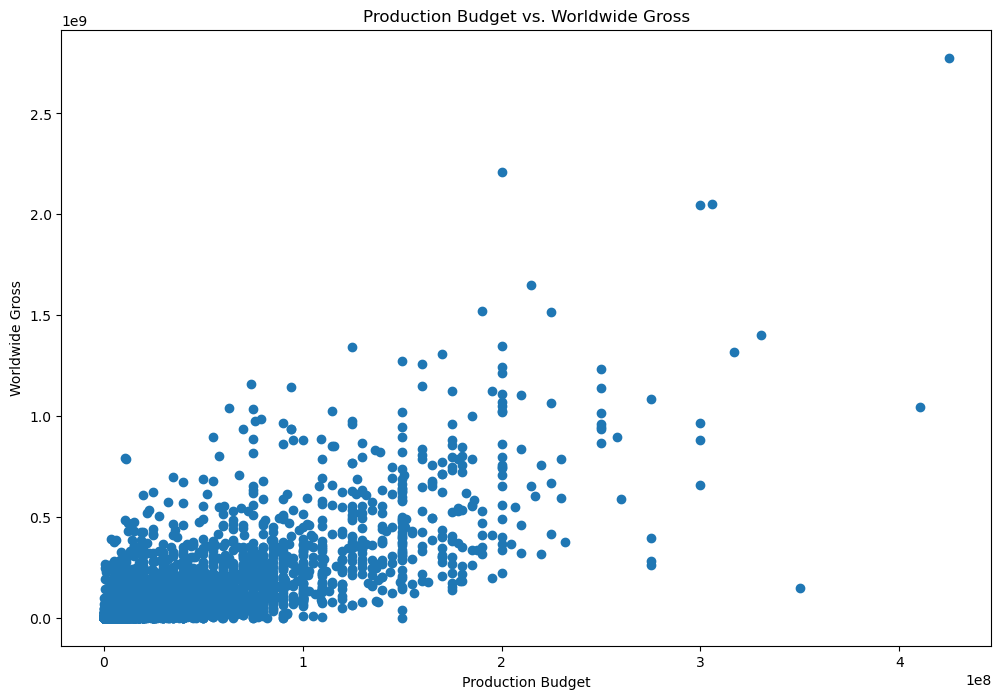

In [11]:
# visualize gross revenue vs budget using a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(movie_budgets_df['production_budget'], movie_budgets_df['worldwide_gross'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.show()